In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import classification_report , confusion_matrix , accuracy_score
from sklearn.model_selection import train_test_split

import cv2
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Input, Dense,Conv2D , MaxPooling2D, Flatten,BatchNormalization,Dropout
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-01-31 21:13:28.911397: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-31 21:13:28.911506: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-31 21:13:29.085092: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
folder_path_no = "/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL"
folder_path_yes = "/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA"

folder_no = os.listdir(folder_path_no)
folder_yes = os.listdir(folder_path_yes)

print(len(folder_no))
print(len(folder_yes))

1341
3875


In [5]:
no_label = [0]*len(folder_no)
yes_label = [1]*len(folder_yes)
labels = no_label + yes_label
print(len(labels))

5216


In [4]:
from sklearn.utils import shuffle
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img


path_no = "/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/"
path_yes = "/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/"


img_width, img_height = 224, 224


datagen = ImageDataGenerator(rescale=1./255)

# Load and preprocess images using the generators
data_no = np.array([img_to_array(load_img(path_no + img, target_size=(img_width, img_height))) for img in os.listdir(path_no)])
data_yes = np.array([img_to_array(load_img(path_yes + img, target_size=(img_width, img_height))) for img in os.listdir(path_yes)])

# Optionally, you can add labels (0 for 'no' class and 1 for 'yes' class)
labels_no = np.zeros(len(data_no))
labels_yes = np.ones(len(data_yes))

data = np.concatenate([data_no, data_yes])
labels = np.concatenate([labels_no, labels_yes])

data, labels = shuffle(data, labels, random_state=42)


In [5]:
data.shape

(5216, 224, 224, 3)

In [6]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the augmenter on the original data
datagen.fit(data)

# Number of augmented images per original image
augmentation_factor = 2
# Augment the data and combine with the original data
augmented_data = []
augmented_labels = []

for i in range(len(data)):
    img = data[i]
    label = labels[i]

    # Reshape the image to (1, height, width, channels) for the flow method
    img = img.reshape((1,) + img.shape)

    # Generate augmented images
    augmented_images = datagen.flow(img, batch_size=1)

    # Append the original image
    augmented_data.append(img.reshape(img.shape[1:]))
    augmented_labels.append(label)

    # Append the augmented images
    for j in range(augmentation_factor - 1):
        augmented_data.append(augmented_images.next().reshape(img.shape[1:]))
        augmented_labels.append(label)

# Convert lists to arrays
augmented_data = np.array(augmented_data)
augmented_labels = np.array(augmented_labels)
augmented_data = augmented_data / 255.0

print("Original data shape:", data.shape)
print("Augmented data shape:", augmented_data.shape)
print("Original labels shape:", labels.shape)
print("Augmented labels shape:", augmented_labels.shape)


Original data shape: (5216, 224, 224, 3)
Augmented data shape: (10432, 224, 224, 3)
Original labels shape: (5216,)
Augmented labels shape: (10432,)


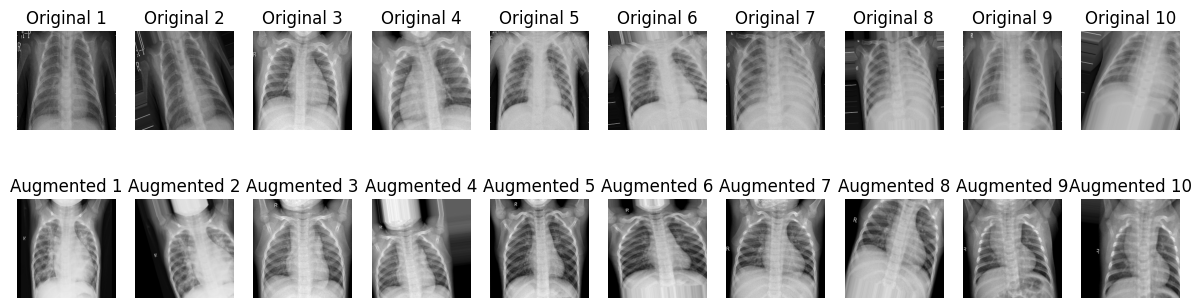

In [7]:
import matplotlib.pyplot as plt


num_images_to_display = 10


fig, axes = plt.subplots(2, num_images_to_display, figsize=(15, 4))


for i in range(num_images_to_display):
    axes[0, i].imshow(augmented_data[i])
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Original {i+1}')


for i in range(num_images_to_display):
    axes[1, i].imshow(augmented_data[i+10])
    axes[1, i].axis('off')
    axes[1, i].set_title(f'Augmented {i+1}')

plt.show()

In [8]:
folder_path_test_normal = "/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/"
folder_path_test_pneumonia = "/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/"

folder_test_no = os.listdir(folder_path_test_normal)
folder_test_yes = os.listdir(folder_path_test_pneumonia)

print(len(folder_test_no))
print(len(folder_test_yes))

234
390


In [9]:
test_no_label = [0]*len(folder_test_no)
test_yes_label = [1]*len(folder_test_yes)
test_labels = test_no_label + test_yes_label
print(len(test_labels))

624


In [10]:
path_no = "/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/"
path_yes = "/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/"

# Define image dimensions
img_width, img_height = 224, 224

# Use ImageDataGenerator for efficient loading and augmentation
datagen = ImageDataGenerator(rescale=1./255)

# Load and preprocess images using the generators
data_no = np.array([img_to_array(load_img(path_no + img, target_size=(img_width, img_height))) for img in os.listdir(path_no)])
data_yes = np.array([img_to_array(load_img(path_yes + img, target_size=(img_width, img_height))) for img in os.listdir(path_yes)])

# Optionally, you can add labels (0 for 'no' class and 1 for 'yes' class)
labels_no = np.zeros(len(data_no))
labels_yes = np.ones(len(data_yes))

# Concatenate the data and labels
data_test = np.concatenate([data_no, data_yes])
labels_test = np.concatenate([labels_no, labels_yes])

# Shuffle the data and labels together
data_test_shuffled, labels_test_shuffled = shuffle(data_test, labels_test, random_state=42)

In [11]:
data_test_normalised=data_test_shuffled/255.0

In [12]:
x_train, x_val, y_train, y_val = train_test_split(augmented_data, augmented_labels, test_size=0.2, random_state=42)
x_test = np.concatenate([x_val, data_test_normalised])
y_test = np.concatenate([y_val, labels_test_shuffled])

In [13]:
print("Training data shape:", x_train.shape)
print("Training labels shape:", y_train.shape)
print("Testing data shape:", x_test.shape)
print("Testing labels shape:", y_test.shape)

Training data shape: (8345, 224, 224, 3)
Training labels shape: (8345,)
Testing data shape: (2711, 224, 224, 3)
Testing labels shape: (2711,)


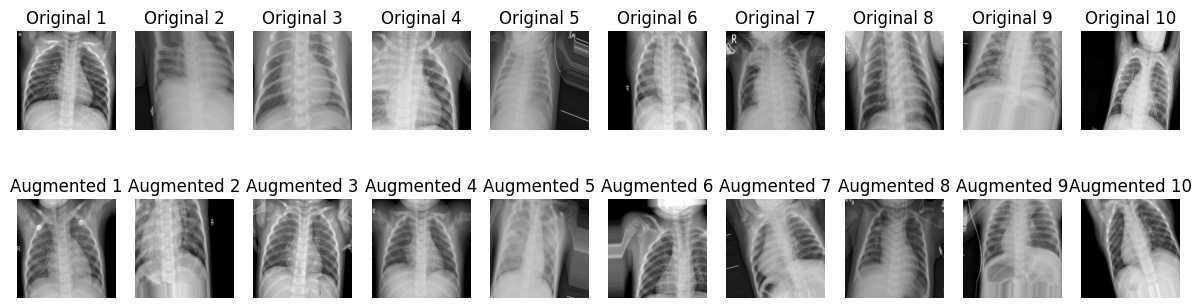

In [14]:
fig, axes = plt.subplots(2, num_images_to_display, figsize=(15, 4))

# Display original images
for i in range(num_images_to_display):
    axes[0, i].imshow(x_train[i])
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Original {i+1}')

# Display augmented images
for i in range(num_images_to_display):
    axes[1, i].imshow(x_test[i])
    axes[1, i].axis('off')
    axes[1, i].set_title(f'Augmented {i+1}')

plt.show()

83683744/83683744 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 46552105 (177.58 MB)
Trainable params: 25690625 (98.00 MB)
Non-trainable params: 20861480 (79.58 MB)
_________________________________________________________________
Epoch 1/50


I0000 00:00:1706730318.347627     103 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


131/131 [==============================] - 61s 380ms/step - loss: 3.5219 - accuracy: 0.9219 - val_loss: 2.2652 - val_accuracy: 0.9148
Epoch 2/50
131/131 [==============================] - 42s 324ms/step - loss: 1.6187 - accuracy: 0.9587 - val_loss: 1.3821 - val_accuracy: 0.9000
Epoch 3/50
131/131 [==============================] - 45s 346ms/step - loss: 0.9946 - accuracy: 0.9696 - val_loss: 0.9911 - val_accuracy: 0.9100
Epoch 4/50
131/131 [==============================] - 45s 341ms/step - loss: 0.6866 - accuracy: 0.9763 - val_loss: 0.7027 - val_accuracy: 0.9329
Epoch 5/50
131/131 [==============================] - 45s 345ms/step - loss: 0.5045 - accuracy: 0.9808 - val_loss: 0.6402 - val_accuracy: 0.9207
Epoch 6/50
131/131 [==============================] - 45s 344ms/step - loss: 0.3979 - accuracy: 0.9791 - val_loss: 0.6277 - val_accuracy: 0.9011
Epoch 7/50
131/131 [==============================] - 45s 344ms/step - loss: 0.3208 - accuracy: 0.9829 - val_loss: 0.4674 - val_accuracy: 0.9

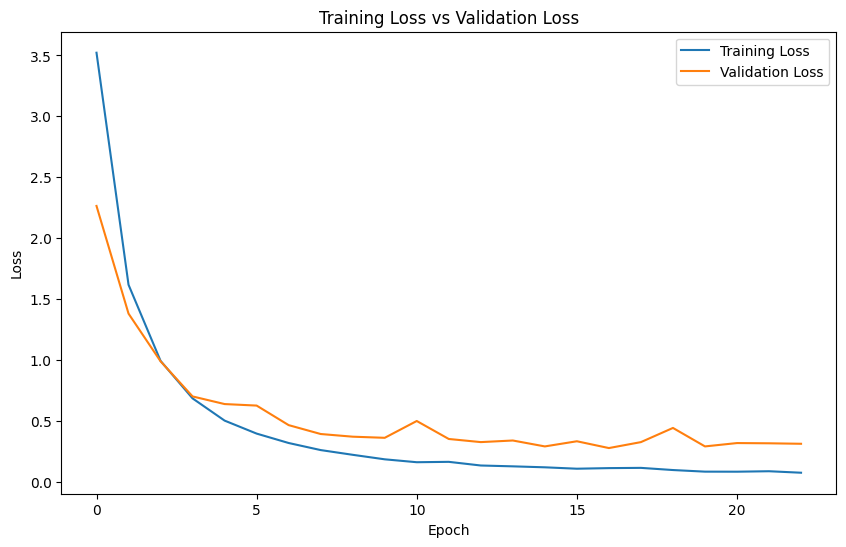

85/85 [==============================] - 15s 138ms/step - loss: 0.2793 - accuracy: 0.9329
Test Loss: 0.2793
Test Accuracy: 93.29%


In [15]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt

# Load the pre-trained Xception model
pre_trained_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers
for layer in pre_trained_model.layers:
    layer.trainable = False

# Create a Sequential model
model = Sequential()

# Add the pre-trained Xception model
model.add(pre_trained_model)

# Flatten layer
model.add(Flatten())

# Fully connected layers with regularization
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True
)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00005), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
history = model.fit(
    x_train, y_train,
    epochs=50,
    batch_size=64,
    shuffle=True,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping]
)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")